[INFO] Using device: cpu
[Epoch 1/20] D loss: 0.9128 | G loss: 0.9567
[Epoch 2/20] D loss: 0.7895 | G loss: 1.3919
[Epoch 3/20] D loss: 0.5706 | G loss: 1.5056
[Epoch 4/20] D loss: 0.5656 | G loss: 1.6374
[Epoch 5/20] D loss: 0.4186 | G loss: 2.1792
[Epoch 6/20] D loss: 0.4627 | G loss: 2.2426
[Epoch 7/20] D loss: 0.3014 | G loss: 3.3411
[Epoch 8/20] D loss: 0.3842 | G loss: 2.7412
[Epoch 9/20] D loss: 0.5539 | G loss: 1.8932
[Epoch 10/20] D loss: 0.8272 | G loss: 2.5481
[Epoch 11/20] D loss: 0.5162 | G loss: 2.6170
[Epoch 12/20] D loss: 0.4404 | G loss: 3.8621
[Epoch 13/20] D loss: 0.0672 | G loss: 7.9649
[Epoch 14/20] D loss: 0.2748 | G loss: 3.7762
[Epoch 15/20] D loss: 0.5551 | G loss: 2.1568
[Epoch 16/20] D loss: 0.6692 | G loss: 2.3181
[Epoch 17/20] D loss: 0.8109 | G loss: 1.9626
[Epoch 18/20] D loss: 0.7122 | G loss: 2.2569
[Epoch 19/20] D loss: 0.8591 | G loss: 2.6520
[Epoch 20/20] D loss: 0.7072 | G loss: 2.4698


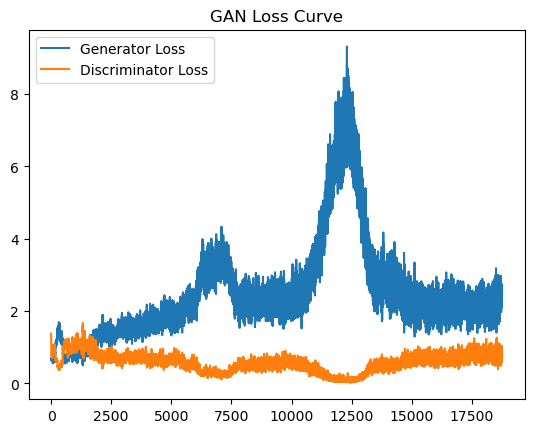

[✅] Saving Final Generated Grid...


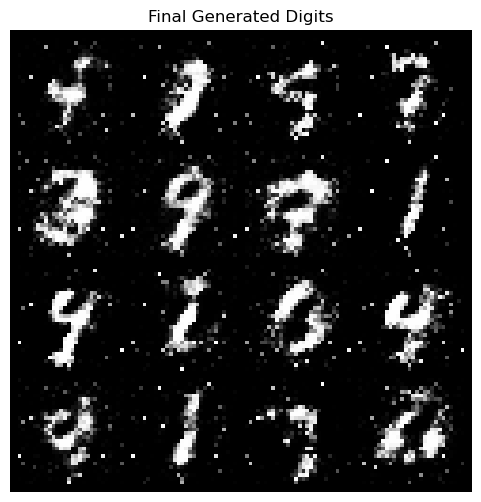

[🎥] Creating GAN training gif...
[✅] Saved gif to: outputs/gan_training.gif


In [1]:
import torch
from torch import nn, optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

from generator import Generator
from discriminator import Discriminator
from utils import get_dataloader

# Hyperparameters
latent_dim = 64
lr = 0.0002
batch_size = 64
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create folders
os.makedirs("outputs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Models
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)

dataloader = get_dataloader(batch_size)

g_losses, d_losses = [], []

print(f"[INFO] Using device: {device}")

for epoch in range(1, epochs + 1):
    for i, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        z = torch.randn(batch_size, latent_dim, device=device)
        fake = G(z)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        D_real = D(real)
        D_fake = D(fake.detach())
        d_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Train Generator
        g_loss = loss_fn(D(fake), real_labels)
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # Save generated images
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        fake_imgs = G(z).detach().cpu()
        grid = vutils.make_grid(fake_imgs, nrow=4, normalize=True)
        vutils.save_image(grid, f"outputs/epoch_{epoch}.png")

    # Save checkpoints
    if epoch % 5 == 0:
        torch.save(G.state_dict(), f"checkpoints/G_epoch_{epoch}.pth")
        torch.save(D.state_dict(), f"checkpoints/D_epoch_{epoch}.pth")

    print(f"[Epoch {epoch}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

# Plot loss
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.legend()
plt.title("GAN Loss Curve")
plt.savefig("outputs/loss_curve.png")
plt.show()
# ============================================
# ✅ Save final grid of digits after training
# ============================================
print("[✅] Saving Final Generated Grid...")

z = torch.randn(16, latent_dim, device=device)
final_fake_imgs = G(z).detach().cpu()
final_grid = vutils.make_grid(final_fake_imgs, nrow=4, normalize=True)
vutils.save_image(final_grid, "outputs/final_grid.png", normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(final_grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Final Generated Digits")
plt.show()

# ============================================
# ✅ Create GIF from epoch images
# ============================================
print("[🎥] Creating GAN training gif...")

from PIL import Image
import glob

frames = []
for img_path in sorted(glob.glob("outputs/epoch_*.png")):
    img = Image.open(img_path)
    frames.append(img)

if frames:
    frames[0].save("outputs/gan_training.gif", format="GIF",
                   append_images=frames[1:], save_all=True, duration=500, loop=0)
    print("[✅] Saved gif to: outputs/gan_training.gif")
else:
    print("[⚠️] No epoch images found to create gif.")
